In [5]:
import pandas as pd
import pm4py
from variant_stats import get_variants_stats
from pm4py.util import ml_utils
import importlib.util
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering

In [2]:
df2 = pd.read_pickle('decision_paths/subset_optimized_simple_size_0.2_fitnessweights_p0.34_f0.33_c0.33_weightmodel_weight_positive_simplified.pickle')

# Initialize an empty list to hold event log rows
event_log0 = []
event_log1 = []

# Iterate over each decision path in the dataset
timestamp = pd.Timestamp('2024-11-14')
case_id = -1
for i in range(len(df2)):
    data = df2['rule_to_simplified_rules'].iloc[i]
    for path in data:
        case_id += 1
        for t,step in enumerate(path):
            # Create an event dictionary for the current step
            event = {
                'case_id': case_id,
                'activity': step.get('feature_value'),
                'timestamp': timestamp + pd.Timedelta(days=t)
            }
            # if event['activity'] in to_remove:
            #     # print(f" I removed {event['activity']} from the log")
            #     continue
            if pd.isna(event['activity']):
                event['activity'] = f'predict{step['predict']}'

            
            # Append the event to the event log
            if path[-1]['predict'] == 1:
                event_log1.append(event)
            else:
                event_log0.append(event)

event_log1 = pd.DataFrame(event_log1)
event_log0 = pd.DataFrame(event_log0)

log1 = event_log1.copy()
log1.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

log0 = event_log0.copy()
log0.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

df0 = get_variants_stats(log0)
df1 = get_variants_stats(log1)

In [8]:
trace_strings = [' '.join(trace) for trace in df0['sequence']]

# Apply TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(trace_strings)  # X is a matrix (n_traces x n_activities)

# Check the shape and feature names
print("TF-IDF Matrix shape:", X.shape)
# print("Feature names:", vectorizer.get_feature_names_out())

TF-IDF Matrix shape: (802, 154)


In [17]:
cluster_num = 20
clustering = SpectralClustering(n_clusters=cluster_num, assign_labels='discretize', random_state=0).fit(X)
labels = clustering.labels_
print(f'we have {cluster_num} clusters')
for i in range(cluster_num):
    print(f' cluster {i}:{len(df0.iloc[labels == i])}')

we have 20 clusters
 cluster 0:42
 cluster 1:31
 cluster 2:21
 cluster 3:40
 cluster 4:37
 cluster 5:51
 cluster 6:56
 cluster 7:19
 cluster 8:39
 cluster 9:35
 cluster 10:39
 cluster 11:52
 cluster 12:36
 cluster 13:27
 cluster 14:65
 cluster 15:68
 cluster 16:65
 cluster 17:18
 cluster 18:43
 cluster 19:18


In [20]:
df0.iloc[labels == 0]['sequence']

514    (functstat_100% -no complaints, dhtn2_No-hyper...
515    (functstat_100% -no complaints, dhtn2_No-hyper...
518    (functstat_100% -no complaints, dhtn2_No-hyper...
519    (functstat_100% -no complaints, dhtn2_No-hyper...
523    (functstat_100% -no complaints, dhtn2_No-hyper...
524    (functstat_100% -no complaints, dhtn2_No-hyper...
527    (functstat_100% -no complaints, dhtn2_No-hyper...
530    (functstat_100% -no complaints, dhtn2_No-hyper...
533    (functstat_100% -no complaints, dhtn2_No-hyper...
535    (functstat_100% -no complaints, dhtn2_No-hyper...
538    (functstat_100% -no complaints, dhtn2_No-hyper...
539    (functstat_100% -no complaints, dhtn2_No-hyper...
541    (functstat_100% -no complaints, dhtn2_No-hyper...
544    (functstat_100% -no complaints, dhtn2_No-hyper...
546    (functstat_100% -no complaints, dhtn2_No-hyper...
547    (functstat_100% -no complaints, dhtn2_No-hyper...
550    (functstat_100% -no complaints, dhtn2_No-hyper...
554    (functstat_100% -no comp

In [22]:
from pm4py.objects.log.obj import EventLog, Trace
from datetime import datetime, timedelta

def logger(sequences,labels, label):
    sequences = sequences.iloc[labels == label]['sequence']
    event_log = EventLog()
    
    # Define a base timestamp for generating artificial times
    base_time = datetime(2024, 1, 1, 0, 0, 0)
    
    # Loop through all sequences and create traces
    for idx, sequence in enumerate(sequences):
        trace = Trace()
        case_id = f"Case_{idx+1}"
    
        for i, activity in enumerate(sequence):
            event = {
                "case:concept:name": case_id,
                "concept:name": activity,
                "time:timestamp": base_time + timedelta(minutes=i)
            }
            trace.append(event)
    
        event_log.append(trace)

    return event_log

In [23]:
events = logger(df0,labels, label=0)

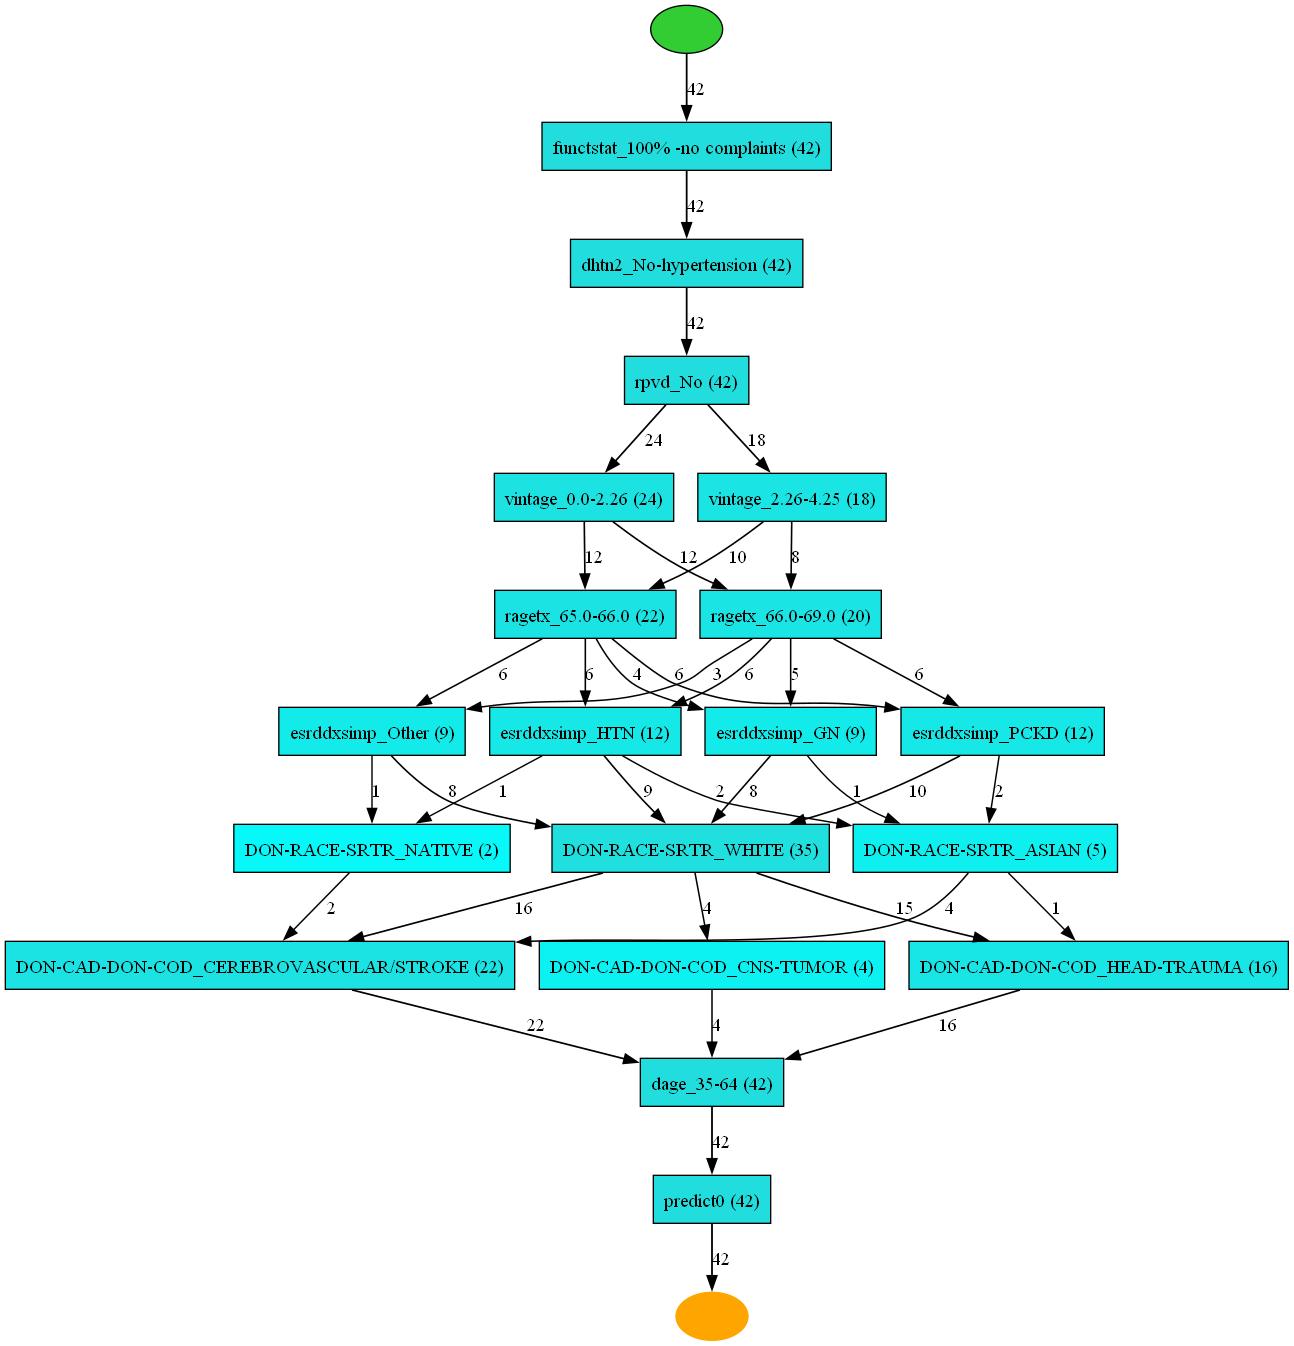

In [26]:
heu_net = heuristics_miner.apply_heu(events)

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

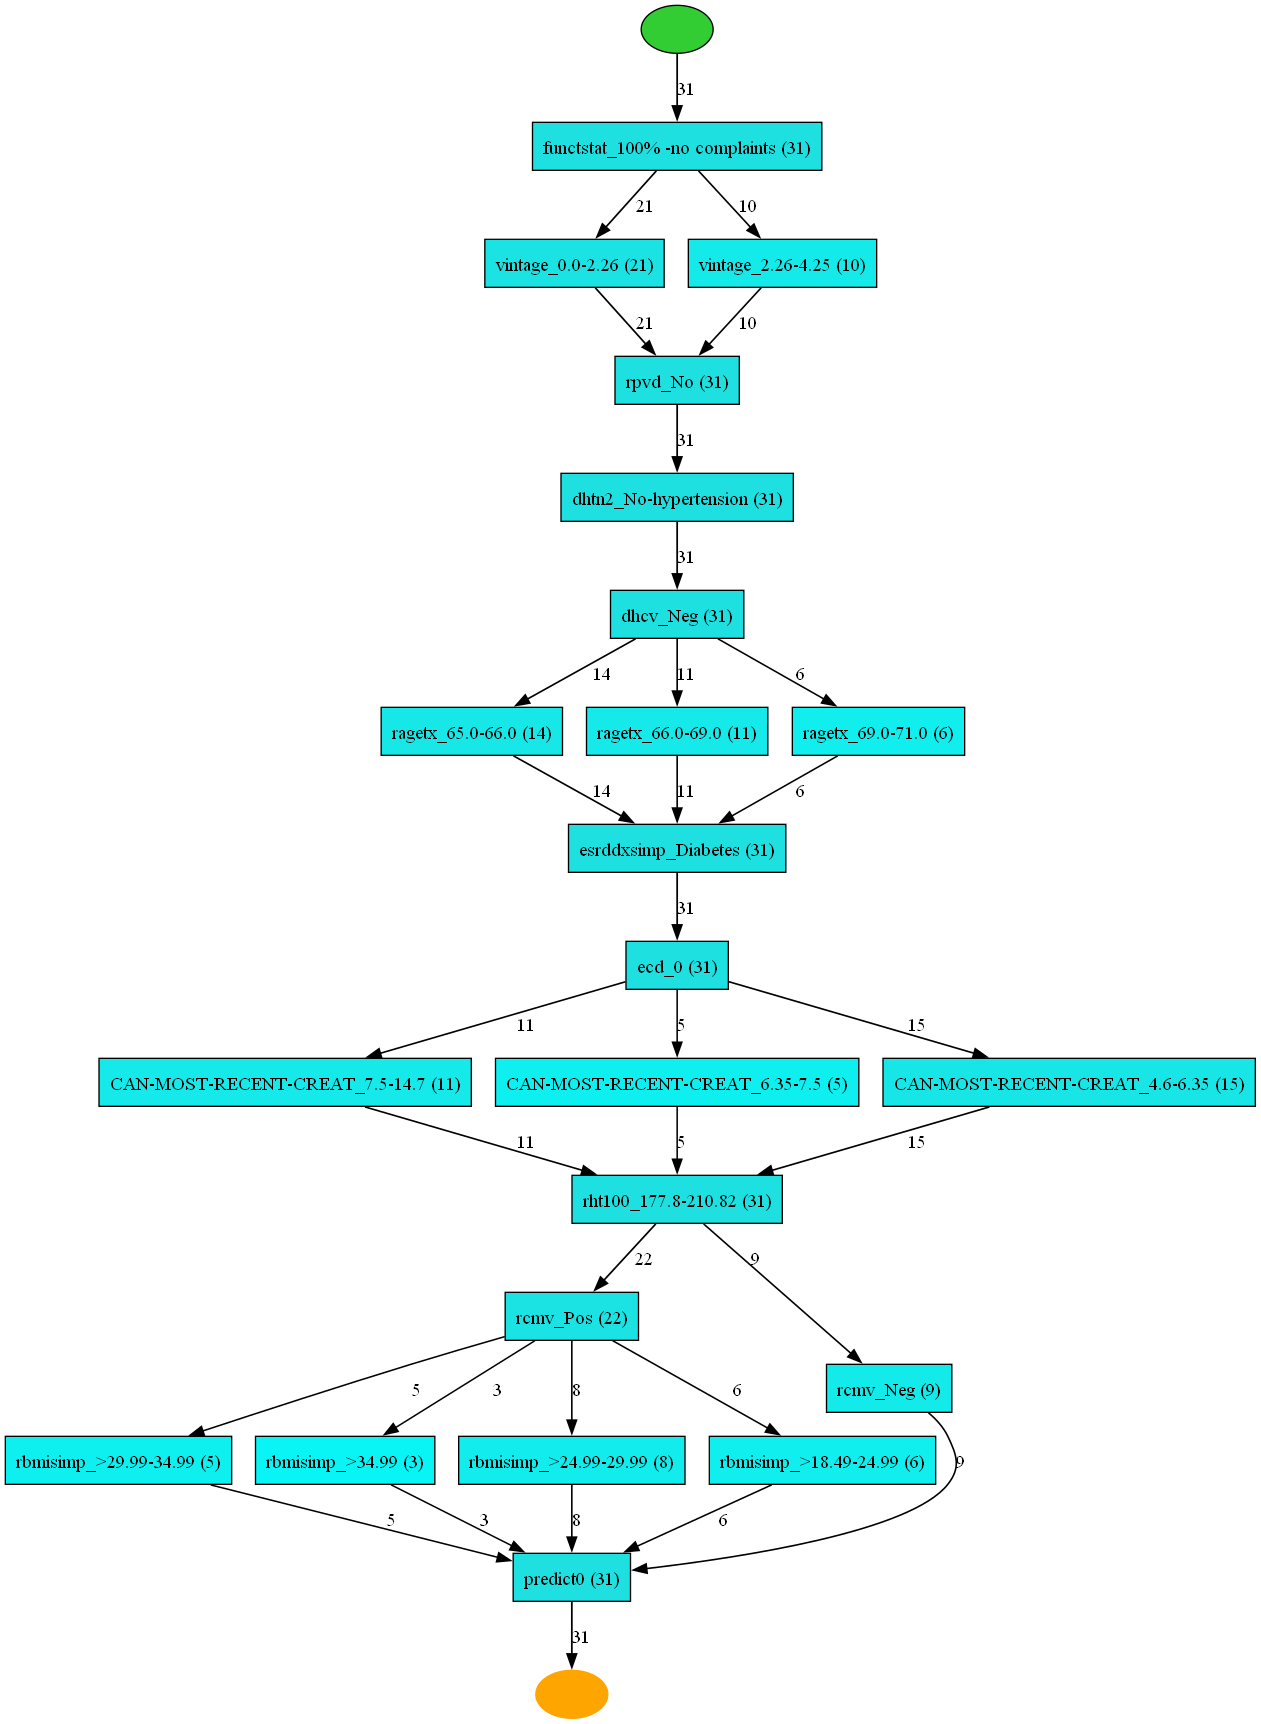

In [27]:
events = logger(df0,labels, label=1)
heu_net = heuristics_miner.apply_heu(events)

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

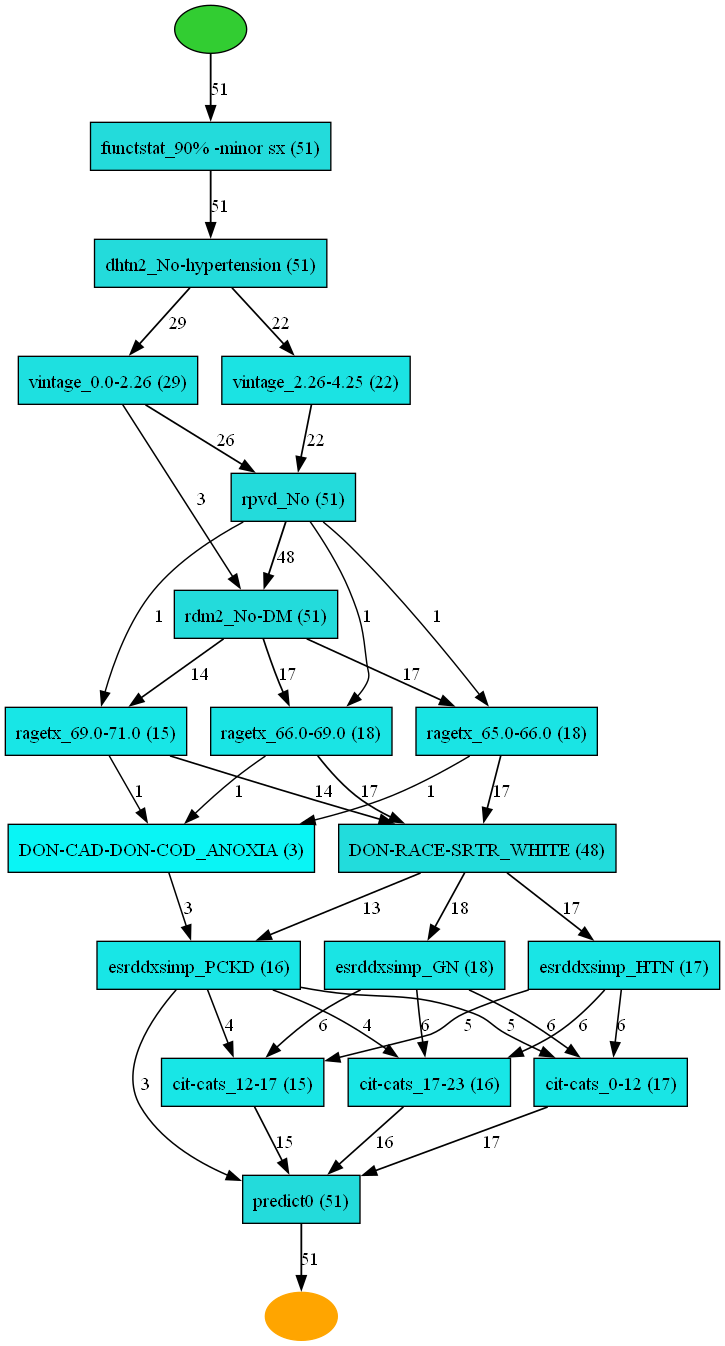

In [31]:
events = logger(df0,labels, label=5)
heu_net = heuristics_miner.apply_heu(events)

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)